### Model Pembanding : Cosine Similarity, Truncated SVD

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Top 5 Recommended Places:
23691                                       Pakkodian Toba
21011    Batu Kursi Raja Siallagan ( Stone Chair of Kin...
33851                                  Menara Pandang Tele
10802                                Aek Rangat Pangururan
8903                                       WF Coffee&Resto
Name: Nama_tempat_wisata, dtype: object
Precision@5: 0.8
Recall@5: 0.041237113402061855
RMSE: 0.7071067811865476
MAE: 0.5
MAP: 0.31638083487561175


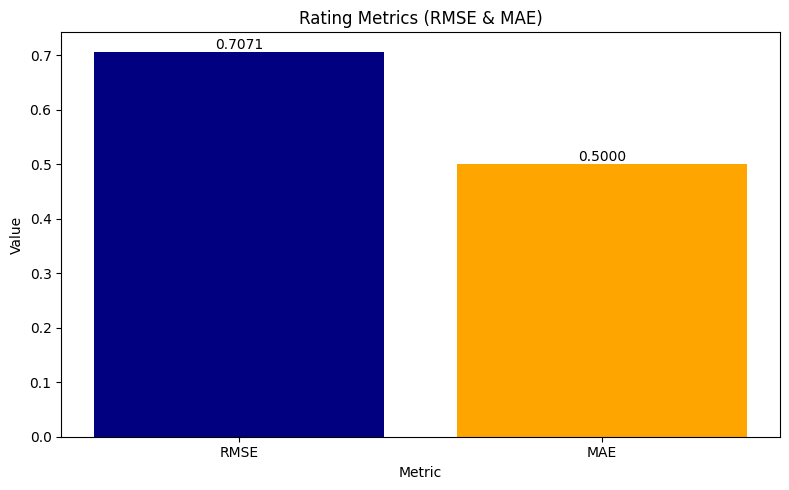

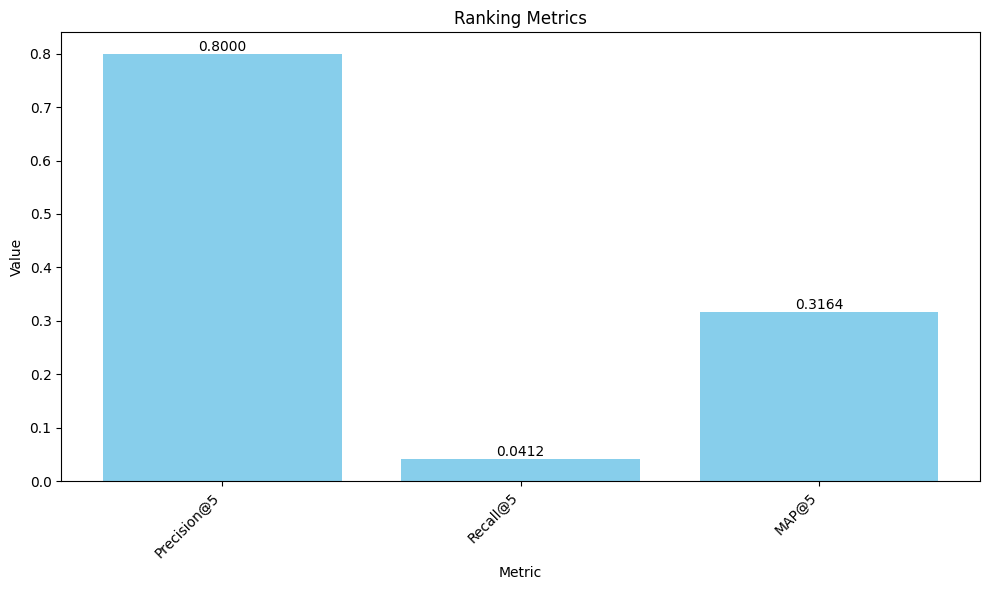

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# 1. Memuat dataset
from google.colab import drive
drive.mount('/content/gdrive')

file_path = '/content/gdrive/MyDrive/Dataset/Tempat-Wisata-Toba-Preprocessing.csv'
dataset = pd.read_csv(file_path)

# 2. Pembagian Data (Train, Validation, Test) - 70%:15%:15%
train_data, test_data = train_test_split(dataset, test_size=0.3, random_state=42)
val_data, test_data = train_test_split(test_data, test_size=0.5, random_state=42)

# 3. Pemrosesan Teks dengan TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1, 2))  # ngram (unigrams dan bigrams)
tfidf_matrix = tfidf_vectorizer.fit_transform(train_data['Reviews'].fillna(''))

# 4. Reduksi Dimensi dengan Truncated SVD
svd = TruncatedSVD(n_components=100, random_state=42)  # Mengatur jumlah komponen laten
reduced_matrix = svd.fit_transform(tfidf_matrix)

# 5. Menghitung Cosine Similarity untuk menghasilkan rekomendasi
cosine_sim = cosine_similarity(reduced_matrix, reduced_matrix)

# Fungsi untuk mendapatkan 5 rekomendasi teratas berdasarkan cosine similarity
def recommend_places(place_index, cosine_sim, top_n=5):
    sim_scores = list(enumerate(cosine_sim[place_index]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    top_places = sim_scores[1:top_n+1]  # Menghindari self-matching, jadi dimulai dari indeks 1
    return [place[0] for place in top_places]  # Mengembalikan indeks tempat wisata teratas

# 6. Fungsi untuk menghitung Precision@k dan Recall@k
def precision_at_k(recommended_places, relevant_indices, k=5):
    recommended_set = set(recommended_places[:k])
    relevant_set = set(relevant_indices)
    intersection = recommended_set.intersection(relevant_set)
    return len(intersection) / k

def recall_at_k(recommended_places, relevant_indices, k=5):
    recommended_set = set(recommended_places[:k])
    relevant_set = set(relevant_indices)
    return len(recommended_set.intersection(relevant_set)) / len(relevant_set)

# 7. Menampilkan rekomendasi tempat wisata berdasarkan cosine similarity
idx = 100  # Indeks tempat wisata yang akan digunakan untuk mendapatkan rekomendasi
top_5_recommendations = recommend_places(idx, cosine_sim, top_n=5)
recommended_places_5 = train_data.iloc[top_5_recommendations]
print("Top 5 Recommended Places:")
print(recommended_places_5['Nama_tempat_wisata'])

# 8. Fungsi untuk menghitung Mean Average Precision (MAP)
def mean_average_precision(recommended_places_list, relevant_indices_list, k=5):
    map_score = 0
    for recommended_places, relevant_indices in zip(recommended_places_list, relevant_indices_list):
        average_precision = 0
        for i in range(min(k, len(recommended_places))):
            if recommended_places[i] in relevant_indices:
                average_precision += precision_at_k(recommended_places, relevant_indices, k=i+1)
        map_score += average_precision / min(k, len(relevant_indices))
    return map_score / len(recommended_places_list)

# 9. Fungsi untuk menghitung RMSE dan MAE
def rmse(predictions, actuals):
    return np.sqrt(mean_squared_error(actuals, predictions))

def mae(predictions, actuals):
    return mean_absolute_error(actuals, predictions)

# 10. Menentukan relevansi berdasarkan rating (rating >= 4)
relevant_data = val_data[val_data['Rating'] >= 4]
relevant_indices = relevant_data['PlaceID'].values

# 11. Mendapatkan 5 rekomendasi teratas untuk tempat pertama dalam data validasi
top_recommendations = recommend_places(0, cosine_sim, top_n=5)

# 12. Menghitung Precision@5 dan Recall@5
precision_5 = precision_at_k(top_recommendations, relevant_indices, k=5)
recall_5 = recall_at_k(top_recommendations, relevant_indices, k=5)

# 13. Menentukan prediksi rating (di sini, kita gunakan rating tempat wisata pertama sebagai prediksi)
valid_predicted_ratings = []
valid_actual_ratings = []

# Cek apakah PlaceID ada di val_data, jika tidak ada maka akan diabaikan
for place_id in top_recommendations:
    matching_ratings = val_data[val_data['PlaceID'] == place_id]['Rating'].values
    if matching_ratings.size > 0:
        valid_predicted_ratings.append(train_data.iloc[place_id]['Rating'])  # Prediksi dari train_data
        valid_actual_ratings.append(matching_ratings[0])  # Rating aktual dari val_data

# 14. Menghitung RMSE dan MAE hanya dengan valid recommendations
if valid_predicted_ratings and valid_actual_ratings:
    rmse_value = rmse(valid_predicted_ratings, valid_actual_ratings)
    mae_value = mae(valid_predicted_ratings, valid_actual_ratings)
else:
    rmse_value = mae_value = "Error: Tidak ada data valid untuk menghitung RMSE/MAE"

# 15. Menghitung MAP (Mean Average Precision)
recommended_places_list = [recommend_places(i, cosine_sim, top_n=5) for i in range(len(val_data))]
relevant_indices_list = [val_data[val_data['Rating'] >= 4]['PlaceID'].values for _ in range(len(val_data))]
map_value = mean_average_precision(recommended_places_list, relevant_indices_list, k=5)

# 16. Menampilkan hasil
print(f"Precision@5: {precision_5}")
print(f"Recall@5: {recall_5}")
print(f"RMSE: {rmse_value}")
print(f"MAE: {mae_value}")
print(f"MAP: {map_value}")

import matplotlib.pyplot as plt

# Data for the plot (replace with your actual RMSE and MAE values)
rmse = rmse_value
mae = mae_value
rating_metrics = {'RMSE': rmse, 'MAE': mae}

plt.figure(figsize=(8, 5))
plt.bar(rating_metrics.keys(), rating_metrics.values(), color=['navy', 'orange'])
plt.title('Rating Metrics (RMSE & MAE)')
plt.xlabel('Metric')
plt.ylabel('Value')

# Add value labels on top of the bars
for metric, value in rating_metrics.items():
    plt.text(metric, value, f'{value:.4f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

import matplotlib.pyplot as plt

# Sample ranking metrics data (replace with your actual data)
ranking_metrics = {
    'Precision@5': precision_5,
    'Recall@5': recall_5,
    'MAP@5': map_value,

}

plt.figure(figsize=(10, 6))
plt.bar(ranking_metrics.keys(), ranking_metrics.values(), color='skyblue')
plt.title('Ranking Metrics')
plt.xlabel('Metric')
plt.ylabel('Value')
plt.xticks(rotation=45, ha='right')

# Add value labels on top of the bars
for metric, value in ranking_metrics.items():
    plt.text(metric, value, f'{value:.4f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

import matplotlib.pyplot as plt
import seaborn as sns

# 17. Visualisasi Cosine Similarity dengan heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cosine_sim, annot=False, cmap='YlGnBu', linewidths=0.5)
plt.title('Cosine Similarity Heatmap')
plt.show()
